In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft

%matplotlib inline

# Parcels

In [2]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import math
from operator import attrgetter

In [7]:
filenames = {'U': "/Users/2311043/Documents/TOROS_U_0315.nc",
             'V': "/Users/2311043/Documents/TOROS_V_0315.nc"}
variables = {'U': 'u_filtered',
             'V': 'v_filtered'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [8]:
# pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
#                              lon = velocity.lon[10,5:20].data,
#                              lat = velocity.lat[10,5:20].data)  # releasing on a line: the end longitude and latitude

pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=10,
                            start=[119.65,23.65],
                            finish=[120.1,23.65])  # releasing on a line: the end longitude and latitude

In [ ]:
output_file = pset.ParticleFile(name="/Users/2311043/Documents/TOROS_Parcels/toros_filtered.zarr", outputdt=timedelta(hours=1))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=25),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\2311043\AppData\Local\Temp\parcels-tmp\lib834cb3ad6af23bb3d5845f56fdd48893_0.dll
INFO: Output files are stored in /Users/2311043/Documents/TOROS_Parcels/toros_filtered.zarr.
 82%|████████▏ | 1767600.0/2160000.0 [00:19<00:06, 59248.16it/s] 

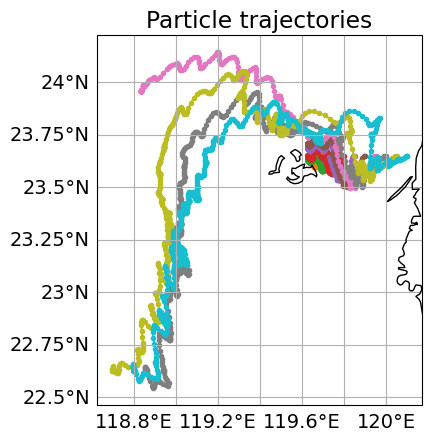

<module 'matplotlib.pyplot' from 'C:\\Users\\2311043\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
plotTrajectoriesFile("/Users/2311043/Documents/TOROS_Parcels/toros_normal.zarr")

In [61]:
data = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros_normal.zarr").load()
data_filtered = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros_filtered.zarr").load()

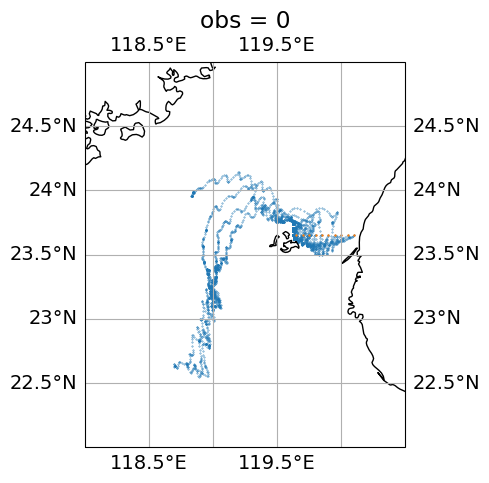

In [70]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})
ax1.set_extent([118,120.5,22,25])
xr.plot.scatter(data,x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.1)
xr.plot.scatter(data_filtered,x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.1)

xr.plot.scatter(data.isel(obs=0),x='lon',y='lat',transform=ccrs.PlateCarree(),s=0.5)
ax1.coastlines()
ax1.gridlines(draw_labels=True)